# Import necessary Python libraries and set up the environment

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
import seaborn as sns
import networkx as nx
from collections import Counter

from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [96]:
!rm -rf ~/.cache/matplotlib/*

plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

## Load dataset from local CSV file

In [7]:
df_course = pd.read_csv('df_course.csv')
df_skill = pd.read_csv('df_skill.csv')
df_job = pd.read_csv('df_job.csv')

course_skill_matrix_df = pd.read_csv('course_skill_matrix.csv')
course_skill_matrix_df.set_index('id', inplace=True)
course_skill_matrix_df.head()

,ACC-AUD-4003-1.1,ACC-AUD-4001-1.1,ACC-PVE-3001-1.1,ACC-AUD-4004-1.1,ACC-AUD-4005-1.1,ACC-AUD-4006-1.1,ACC-AUD-4007-1.1,ACC-AUD-4008-1.1,ACC-MAC-3001-1.1,ACC-IAD-3001-1.1,...,WPH-QUA-5021-1.1,WPH-TEM-3017-1.1,WPH-TEM-3011-1.1,WPH-WSH-2079-1.1,WPH-WSH-2080-1.1,WPH-WSH-2081-1.1,WPH-WSH-2082-1.1,WPH-WSH-2083-1.1,WPH-WSH-1084-1.1,WPH-WSH-2085-1.1
id,,,,,,,,,,,,,,,,,,,,,
Microsoft Excel 2013 Pivot Table Proficiency,0.179757,0.183393,0.092048,0.221600,0.126661,0.178061,0.107612,0.130708,0.252675,0.221702,...,0.136313,0.082767,0.188825,0.139225,0.101395,0.130029,0.122439,0.138533,0.042115,0.067245
Air-Conditioning - Basic Maintenance for Home Split Unit,0.154118,0.162001,0.134393,0.148149,0.238262,0.056324,0.191643,0.117338,0.104030,0.205753,...,0.214571,0.096221,0.226100,0.359552,0.331665,0.383805,0.285679,0.360446,0.239443,0.244653
Certificate in Athlete Life Coaching,0.251671,0.326717,0.109453,0.348112,0.299361,0.250076,0.242755,0.236788,0.161152,0.194219,...,0.062562,0.006293,0.117493,0.166548,0.098454,0.122237,0.098785,0.152214,0.212942,0.077294
Certificate Course in 2nd Grade Computer Aided Drafting (For Steam Engineers),0.054930,0.119332,-0.016256,0.181255,0.160762,0.184661,0.122493,0.047538,-0.012992,0.070863,...,0.068388,0.053957,0.178439,0.108953,0.136365,0.137614,0.082798,0.072413,0.113518,0.143892
Certificate Course in 2nd Grade Mechanics II (For Steam Engineers),0.058651,0.064089,-0.023753,0.023501,0.051501,-0.043339,0.009543,-0.019365,0.030119,0.052614,...,0.041003,0.037123,0.125917,0.072487,0.110095,0.173598,0.102159,0.157383,0.097563,0.164849


## Filtering, Visualizing, and Analyzing Course-Skill Matrix

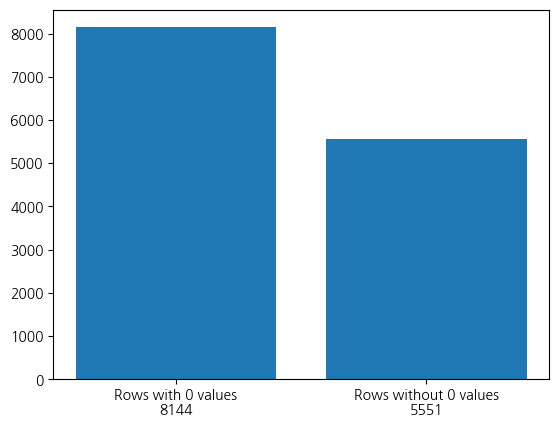

In [10]:
course_skill_matrix = course_skill_matrix_df.values
course_skill_matrix.shape

threshold = 0.6

filtered_matrix = np.where(course_skill_matrix < threshold, 0, course_skill_matrix)

# Replace non-zero values with 1
filtered_matrix[filtered_matrix != 0] = 1

# Count rows with at least one "1"
row_counts = np.sum(filtered_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = filtered_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

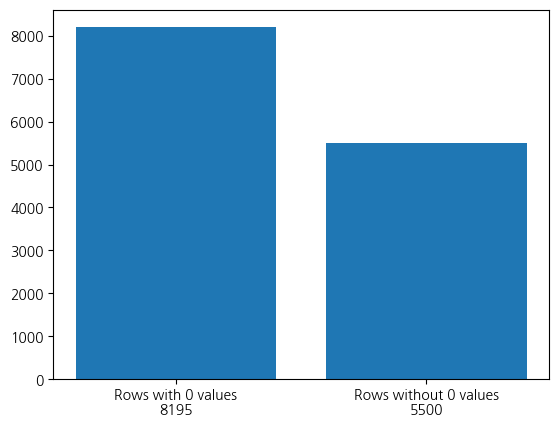

In [11]:
# Transpose the matrix
transposed_matrix = np.transpose(filtered_matrix)

# Perform matrix multiplication
monopartite_matrix = np.dot(filtered_matrix, transposed_matrix)
monopartite_matrix[np.diag_indices_from(monopartite_matrix)] = 0

# Count rows with at least one "1"
row_counts = np.sum(monopartite_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = monopartite_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

# Constructing a Course Network and Calculating Course Coverage

In [12]:
#Construct Course network using monopartite_matrix
G = nx.Graph()
n = monopartite_matrix.shape[0]

for i in range(n):
    for j in range(i + 1, n):
        weight = float(monopartite_matrix[i][j])  
        if weight > 0:
          G.add_edge(i, j, weight=weight)

In [13]:
#add course name attributes to each node
node_names = course_skill_matrix_df.index
node_indices = np.arange(filtered_matrix.shape[0])
node_index_to_name = {index: name for index, name in zip(node_indices, node_names)}
for node in G.nodes:
    G.nodes[node]['name'] = node_index_to_name[node]

In [14]:
#extract id(course name) and label from course dataframe
df_course_columns = ['id', 'course_label']
#by matching with the names(ids) of each node, assign labels to each node
for node in G.nodes():
    node_name = G.nodes[node]['name']
    corresponding_row = df_course[df_course['id'] == node_name]
    if not corresponding_row.empty:
        label_value = corresponding_row.iloc[0][df_course_columns[1]]
        G.nodes[node]['label'] = label_value
    else:
        G.nodes[node]['label'] = 'Unknown'

In [15]:
#Calculate course_coverage for each node and assign
row_sums = np.sum(filtered_matrix, axis=1)
course_index = course_skill_matrix_df.index
course_coverage_df = pd.DataFrame(data={'row_sum': row_sums}, index=course_index)

# Iterate through the nodes in the graph and update the 'row_sum' attribute
for node in G.nodes():
    node_name = G.nodes[node]['name']
    if node_name in course_coverage_df.index:
        G.nodes[node]['course_coverage'] = course_coverage_df.loc[node_name, 'row_sum']

# Constructing a Bipartite Network and Calculating Course Specificity

In [39]:
#To calcualte course specificity, start with making a bipartite network of course-job/skill
B = nx.Graph()

course_names = course_skill_matrix_df.index
skill_names = course_skill_matrix_df.columns

B.add_nodes_from(course_names, bipartite=0) 
B.add_nodes_from(skill_names, bipartite=1)   

for i in range(len(course_names)):
    course_name = course_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix[i, j]
        if value == 1:
            skill_name = skill_names[j]
            B.add_edge(course_name, skill_name)

In [40]:
#assign labels to each node in B
labels_course = {node: row['course_label'] for node, row in df_course.set_index('id').iterrows()}
labels_skill = {node: row['skill_label'] for node, row in df_skill.set_index('id').iterrows()}
labels_job = {node: row['job_label'] for node, row in df_job.set_index('id').iterrows()}

for node in B.nodes():
    if B.nodes[node]['bipartite'] == 0:
        B.nodes[node]['course_label'] = labels_course.get(node)
    elif B.nodes[node]['bipartite'] == 1:
        B.nodes[node]['skill_label'] = labels_skill.get(node) or labels_job.get(node)

In [41]:
# Calculate kc0 and kpo values from the edge_list
edge_list = nx.to_pandas_edgelist(B)
kc0 = edge_list.groupby('source')['target'].count().reset_index()
kp0 = edge_list.groupby('target')['source'].count().reset_index()

#Save kc0 in source nodes as 'kc0' attributes
for node, kc0_value in zip(kc0['source'], kc0['target']):
    if node in B.nodes:
        B.nodes[node]['kc0'] = kc0_value

#Save kp0 in target nodes as 'kp0' attributes
for node, kp0_value in zip(kp0['target'], kp0['source']):
    if node in B.nodes:
        B.nodes[node]['kp0'] = kp0_value

In [42]:
# Loop for calculating kc1 to kc2
for iteration in range(1, 3):  # Assuming you want to calculate up to kc2

    # Calculate kc_i for each source node
    for source_node in B.nodes:
        neighbors = list(B.neighbors(source_node))

        # Sum kp(i-1) attributes of neighbors that have 'kp(i-1)' values
        kp_sum = sum(B.nodes[neighbor]['kp{}'.format(iteration-1)] for neighbor in neighbors
                     if 'kp{}'.format(iteration-1) in B.nodes[neighbor])

        # Divide the sum of kp0 attribute by inverse of kc0 of the source node
        if 'kc0' in B.nodes[source_node]:
            kc0_value = B.nodes[source_node]['kc0']
            B.nodes[source_node]['kc{}'.format(iteration)] = kp_sum / kc0_value

    # Calculate kp_i for each target node
    for target_node in B.nodes:
        source_node_neighbors = list(B.neighbors(target_node))

        # Sum kc(i) attributes of source node neighbors
        kc_sum = sum(B.nodes[source]['kc{}'.format(iteration-1)] for source in source_node_neighbors
                    if 'kc{}'.format(iteration-1) in B.nodes[source])

        # Divide the sum of kc(i) attribute by kpo of the target node
        if 'kp0' in B.nodes[target_node]:
            kp0_value = B.nodes[target_node]['kp0']
            B.nodes[target_node]['kp{}'.format(iteration)] = kc_sum / kp0_value

In [43]:
# Extract data from source nodes
source_data = {'Node': []}
for i in range(3):  # Assuming you want kc0 to kc10
    source_data[f'kc{i}'] = []

for node in B.nodes:
    source_data['Node'].append(node)
    for i in range(3):
        attribute_key = f'kc{i}'
        source_data[attribute_key].append(B.nodes[node].get(attribute_key, np.nan))

# Create a dataframe from the extracted data
kc_df = pd.DataFrame(source_data)
kc_df = kc_df.dropna()
kc_df

,Node,kc0,kc1,kc2
2,Certificate in Athlete Life Coaching,2.0,43.500000,8.668139
3,Certificate Course in 2nd Grade Computer Aided...,7.0,34.142857,6.865049
7,Certificate Course in 2nd Grade Engineering Ma...,1.0,4.000000,1.750000
9,Certificate Course in 1st Grade Engineering Ma...,2.0,4.000000,1.875000
11,Joint ITE-UPEC Certificate in Pre-Hospital Eme...,2.0,37.000000,2.956938
...,...,...,...,...
13684,Fundamentals of Computer Programming (Synchron...,8.0,7.875000,9.354419
13685,Good Dispensing Practice (part of PDC2 of Adva...,1.0,4.000000,2.750000
13689,Audit Management I,3.0,19.666667,19.426812
13690,"""Think Out Of The Box"" (Synchronous e-Learning)",1.0,22.000000,13.000000


# Aggregating Course Influence and Specificity in VET Sectors

In [44]:
# create dataframe by extract course_name, coverage, label and degree of each node from the course network
course_influence = []
for node in G.nodes():
    node_data = {
        'Node': G.nodes[node]['name'],
        'coverage': G.nodes[node]['course_coverage'],
        'label':G.nodes[node]['label'],
        'degree': G.degree(node)}  
    course_influence.append(node_data)

# Create a dataframe
course_influence_df = pd.DataFrame(course_influence)
course_influence_df['course_influence'] = course_influence_df['coverage'] / course_influence_df['degree']
course_influence_df

,Node,coverage,label,degree,course_influence
0,Certificate in Athlete Life Coaching,2.0,Sports,83,0.024096
1,Performance Management & Career Conversation (...,27.0,Leadership & People Management,412,0.065534
2,Continuous Improvement Management,14.0,Productivity and Innovation,288,0.048611
3,Design Transformative Learning and Development...,14.0,MICE & Events,292,0.047945
4,People Development (Level 5),23.0,Leadership & People Management,416,0.055288
...,...,...,...,...,...
5495,International and Comparative Insolvency Law i...,1.0,Legal,1,1.000000
5496,Corporate Insolvency Law,1.0,Business Management,1,1.000000
5497,Working with Families (In-Service Staff),1.0,Healthcare,1,1.000000
5498,Working with Families (New Hire),1.0,Healthcare,1,1.000000


In [45]:
#To compare impact and ubiquity, merge the two dataframes
merged_df = pd.merge(kc_df, course_influence_df, on='Node', how='left')
merged_df = merged_df.dropna().reset_index()
merged_df = merged_df.drop(columns=['index'])
merged_df

,Node,kc0,kc1,kc2,coverage,label,degree,course_influence
0,Certificate in Athlete Life Coaching,2.0,43.500000,8.668139,2.0,Sports,83.0,0.024096
1,Certificate Course in 2nd Grade Computer Aided...,7.0,34.142857,6.865049,7.0,Engineering,83.0,0.084337
2,Certificate Course in 2nd Grade Engineering Ma...,1.0,4.000000,1.750000,1.0,Engineering,3.0,0.333333
3,Certificate Course in 1st Grade Engineering Ma...,2.0,4.000000,1.875000,2.0,Engineering,5.0,0.400000
4,Joint ITE-UPEC Certificate in Pre-Hospital Eme...,2.0,37.000000,2.956938,2.0,Healthcare,56.0,0.035714
...,...,...,...,...,...,...,...,...
5495,Fundamentals of Computer Programming (Synchron...,8.0,7.875000,9.354419,8.0,Information and Communications,32.0,0.250000
5496,Good Dispensing Practice (part of PDC2 of Adva...,1.0,4.000000,2.750000,1.0,Pharmaceutical and Biotechnology,3.0,0.333333
5497,Audit Management I,3.0,19.666667,19.426812,3.0,Healthcare,34.0,0.088235
5498,"""Think Out Of The Box"" (Synchronous e-Learning)",1.0,22.000000,13.000000,1.0,Productivity and Innovation,21.0,0.047619


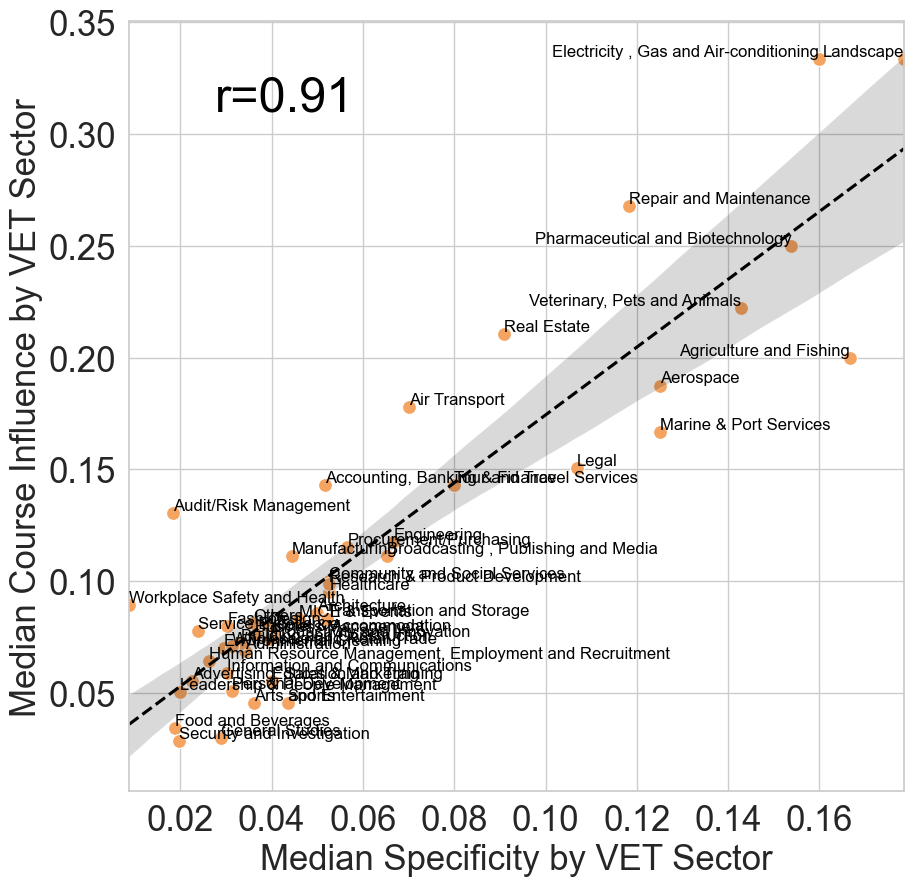

In [93]:
sector_df = merged_df.groupby('label')[['kc0','kc1','kc2','course_influence']].median().reset_index()

# Count the number of courses in each group
course_counts = merged_df['label'].value_counts().reset_index()
course_counts.columns = ['label', 'course_count']

# Merge the median_kc DataFrame with course_counts
sector_df = pd.merge(sector_df, course_counts, on='label')

# Filter out groups with counts under 5
sector_df_filtered = sector_df[sector_df['course_count'] >= 5]
sector_df_filtered = sector_df_filtered.drop('course_count', axis=1)

# Calculate the inverse of kc1
sector_df_filtered['specificity'] = 1 / sector_df_filtered['kc1']

# Create a scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x='specificity', y='course_influence', data=sector_df_filtered, color='sandybrown', s=100)

# Draw a fitted line (regression line)
sns.regplot(x='specificity', y='course_influence', data=sector_df_filtered, scatter=False, color='grey', line_kws={'linestyle': '--', 'color': 'black'})

# Calculate the correlation coefficient'b
correlation_coefficient_inverse_kc1 = sector_df_filtered['specificity'].corr(sector_df_filtered['course_influence'])

# Annotate each point with its corresponding label
for label, x, y in zip(sector_df_filtered['label'], sector_df_filtered['specificity'], sector_df_filtered['course_influence']):
    ha_value = 'left' if label not in ['Landscape', 'Pharmaceutical and Biotechnology', 'Veterinary, Pets and Animals','Agriculture and Fishing', 'Electricity , Gas and Air-conditioning'] else 'right'
    plt.text(x, y, label, fontsize=12, ha=ha_value, va='bottom', color='black')

    
# Annotate the plot with the correlation coefficient
plt.annotate(f'r={correlation_coefficient_inverse_kc1:.2f}',
             xy=(0.2, 0.90), xycoords='axes fraction',
             ha='center', va='center', fontsize=35, color='black')

# Set x-axis limits
plt.xlabel('Median Specificity by VET Sector', fontsize=25)
plt.ylabel('Median Course Influence by VET Sector', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True) 

plt.show()

# Calculate Transferability Value for Four Economies and Skill Diversity

In [57]:
def process_transferability_data(csv_file, skill_df, B, G, transferability_type):
    # Read CSV file
    transferability_data = pd.read_csv(csv_file)
    transferability_data = transferability_data.rename(columns={'Title of Priority Skill': 'TSC_CCS Title', 'Description of Priority Skill': 'TSC_CCS Description'})
    df_skill_original = pd.read_csv(skill_df)
    
    def percentage_to_float(percentage_str):
        return float(percentage_str.strip('%'))

    # Apply the function to the DataFrame
    transferability_data['Demand Growth'] = transferability_data['Demand Growth'].apply(percentage_to_float)
    transferability_data['label'] = transferability_type

    # Merge dataframes and drop NaN values
    skill_data = pd.merge(transferability_data, df_skill_original, on=['TSC_CCS Title', 'TSC_CCS Description'], how='left')
    skill_data = skill_data.dropna()
    skill_data = skill_data[['TSC_CCS Code', 'label', 'TSC_CCS Title', 'TSC_CCS Description', 'Transferability']]

    # Convert dataframe to dictionary
    skills_data = skill_data.set_index('TSC_CCS Code')['Transferability'].to_dict()

    # Extract skill_names from skills_data
    skill_names = list(skills_data.keys())

    # Assign values from skills_data to nodes in the graph
    for skill_name in skill_names:
        value = skills_data[skill_name]
        B.nodes[skill_name][f'{transferability_type}_transferability'] = value

    # Create a dictionary to store the total node sizes for each course node
    course_sizes = {}

    # Iterate through the course nodes
    for course_node in B.nodes:
        total_size = 0

        # Get the skill node neighbors of the course node
        skill_neighbors = [neighbor_node for neighbor_node in B.neighbors(course_node) if B.nodes[neighbor_node]['bipartite'] == 1]

        for skill_node in skill_neighbors:
            if f'{transferability_type}_transferability' in B.nodes[skill_node]:
                # Correctly accumulate the transferability_value
                transferability_value = B.nodes[skill_node][f'{transferability_type}_transferability']
                total_size += transferability_value

        # Store the total size for the course node
        course_sizes[course_node] = total_size

    # Assign '{transferability_type}_transferability' attribute to the nodes in G
    for course_node, transferability_value in course_sizes.items():
        # Check if the course node is in G based on the 'name' attribute
        nodes_with_name = [node for node in G.nodes if 'name' in G.nodes[node] and G.nodes[node]['name'] == course_node]
        if nodes_with_name:
            G.nodes[nodes_with_name[0]][f'{transferability_type}_transferability'] = transferability_value

In [58]:
process_transferability_data('Green Economy.csv', 'df_skill_original.csv', B, G, 'green')
process_transferability_data('Digital Economy.csv', 'df_skill_original.csv', B, G, 'digital')
process_transferability_data('Care Economy.csv', 'df_skill_original.csv', B, G, 'care')
process_transferability_data('I4.0 Economy.csv', 'df_skill_original.csv', B, G, 'i40')

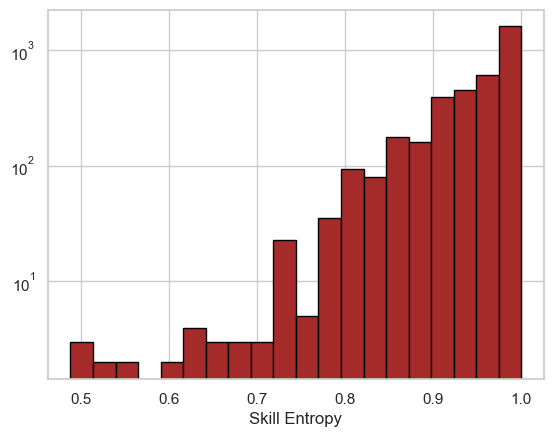

In [59]:
# Assign values from skills_data to partition 1 nodes
skill_data = df_skill.set_index('id')['skill_label'].to_dict()

for skill_name in skill_names:
    if skill_name in skill_data:
        value =  skill_data[skill_name]
        B.nodes[skill_name]['skill_category'] = value  # Add 'value' attribute to the node
        
# Calculate the overall unique job sectors
unique_skill_categories = set()
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'skill_category' in skill_node[1]:
        unique_skill_categories.add(skill_node[1]['skill_category'])

# Create a dictionary to store conditional probabilities of job sectors given skill neighbors
conditional_probs = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Count the occurrence of each job sector in the neighbors
        skill_category_counts = {}
        for skill_neighbor in skill_neighbors:
            if 'skill_category' in B.nodes[skill_neighbor]:
                skill_category = B.nodes[skill_neighbor]['skill_category']
                skill_category_counts[skill_category] = skill_category_counts.get(skill_category, 0) + 1

        # Calculate conditional probabilities
        conditional_probs[course_name] = {skill_category: count / len(skill_neighbors) for skill_category, count in skill_category_counts.items()}

# Calculate entropy for each course node using scipy.stats.entropy
skill_entropy_values = {}
for course_name, conditional_probabilities in conditional_probs.items():
    prob_values = np.array(list(conditional_probabilities.values()))

    num_groups = len(conditional_probs[course_name])

    if num_groups >= 2:
       entropy_value = entropy(prob_values, base=num_groups)
    else:
       entropy_value = None  # Assign None for courses with no skill categories

    skill_entropy_values[course_name] = entropy_value

    # Create a histogram to visualize the distribution of entropy values
entropy_list = [value for value in skill_entropy_values.values() if value is not None]
plt.hist(entropy_list, bins=20, color='brown', edgecolor='black')
plt.xlabel('Skill Entropy')
plt.yscale('log')
plt.show()

In [61]:
for node in G.nodes(data=True):
    node_name = node[1]['name']  # Assuming 'name' is the attribute to match
    if node_name in skill_entropy_values:
        entropy_value = skill_entropy_values[node_name]
        G.nodes[node[0]]['skill_entropy_value'] = entropy_value

# Regression Analysis of Course Influence with Transferability and Skill Diversity

In [63]:
linear_df_list = []
for node in G.nodes():
    linear_df_data = {
        'course_name': G.nodes[node]['name'],
        'coverage': G.nodes[node]['course_coverage'],
        'green_transferability': G.nodes[node]['green_transferability'],
        'digital_transferability': G.nodes[node]['digital_transferability'],
        'care_transferability': G.nodes[node]['care_transferability'],
        'i40_transferability': G.nodes[node]['i40_transferability'],
        'label':G.nodes[node]['label'],
        'skill_diversity': G.nodes[node].get('skill_entropy_value', None), 
        'degree': G.degree(node)}  # Add the 'degree' attribute
    linear_df_list.append(linear_df_data)

# Create a Pandas DataFrame
linear_df = pd.DataFrame(linear_df_list)
linear_df['course_influence'] = linear_df['coverage'] / linear_df['degree']
linear_df.head()

,course_name,coverage,green_transferability,digital_transferability,care_transferability,i40_transferability,label,skill_diversity,degree,course_influence
0,Certificate in Athlete Life Coaching,2.0,0,0,433,0,Sports,1.000000,83,0.024096
1,Performance Management & Career Conversation (...,27.0,0,0,108,0,Leadership & People Management,0.887780,412,0.065534
2,Continuous Improvement Management,14.0,0,0,1574,613,Productivity and Innovation,0.982337,288,0.048611
3,Design Transformative Learning and Development...,14.0,0,0,764,0,MICE & Events,0.933785,292,0.047945
4,People Development (Level 5),23.0,0,0,857,0,Leadership & People Management,0.934668,416,0.055288


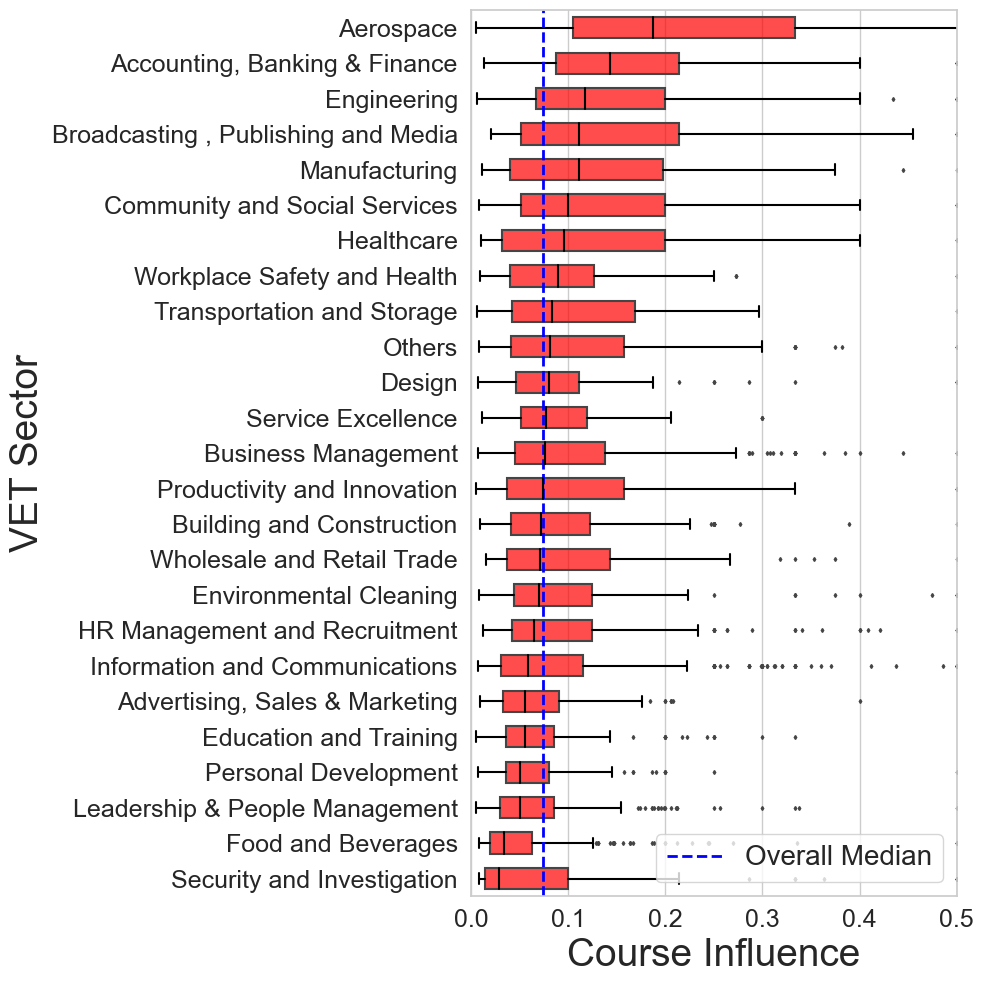

In [94]:
# Calculate the median course impact
median_course_impact = linear_df['course_influence'].median()

# Calculate the count for each sector
label_counts = linear_df['label'].value_counts()

# Filter labels with count below 50
filtered_labels = label_counts[label_counts >= 50].index

# Create a filtered DataFrame
filtered_df = linear_df[linear_df['label'].isin(filtered_labels)]

# Update the sector name
sector_to_update = "Human Resource Management, Employment and Recruitment"
new_sector_name = "HR Management and Recruitment"
filtered_df.loc[filtered_df['label'] == sector_to_update, 'label'] = new_sector_name

# Calculate the median for each sector and sort by it
median_values = filtered_df.groupby('label')['course_influence'].median().sort_values(ascending=False)
sorted_labels = median_values.index

# Plot the boxplot using seaborn
plt.figure(figsize=(10, 10))
box_plot = sns.boxplot(x='course_influence', y='label', data=filtered_df, order=sorted_labels, fliersize=2, width=0.6)

# Set the color and transparency for the boxes
box_color = (1, 0, 0, 0.7)  # Red with alpha 0.7
for patch in box_plot.artists:
    patch.set_facecolor(box_color)

# Set the color for the whiskers, caps, and fliers
line_color = 'black'
for line in box_plot.lines:
    line.set_color(line_color)

plt.xlabel('Course Influence', fontsize=28)
plt.ylabel('VET Sector', fontsize=28)  # Set y-label to VET Sector
plt.xticks(fontsize=18)  # Adjust x-tick label font size
plt.yticks(fontsize=18)  # Adjust y-tick label font size

# Limit the x-axis to the range 0 to 2.0
plt.xlim(0, 0.5)

# Add a vertical line for the overall median
plt.axvline(x=median_course_impact, color='blue', linestyle='--', linewidth=2, label='Overall Median')

plt.legend(loc='lower right', fontsize=20) 
plt.margins(x=0, y=0)
plt.tight_layout()

plt.show()

In [74]:
# Regression Analysis of Course Influence Without Skill Diversity
regression_data = linear_df.copy()
regression_data .dropna(subset=['skill_diversity'], inplace=True)

scaler = MinMaxScaler()
columns_to_normalize = ['green_transferability', 'digital_transferability', 'care_transferability','i40_transferability']
regression_data [columns_to_normalize] = scaler.fit_transform(regression_data [columns_to_normalize])

# Fit the linear regression model with dummy variables for 'label'
model_1 = sm.OLS.from_formula('course_influence ~ green_transferability+digital_transferability+care_transferability+i40_transferability+skill_diversity+C(label)+1', regression_data).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       course_influence   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     9.359
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.87e-72
Time:                        18:15:42   Log-Likelihood:                 1375.2
No. Observations:                3637   AIC:                            -2634.
Df Residuals:                    3579   BIC:                            -2275.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   0.6598      0.047     14.064      0.000       0.568       0.752
C(label)[T.Administration]                                                 -0.0759      0.044     -1.744      0.081      -0.161       0.009
C(label)[T.Advertising, Sales & Marketing]                                 -0.0917      0.021     -4.350      0.000      -0.133      -0.050
C(label)[T.Aerospace]                                                       0.0604      0.033      1.841      0.066      -0.004       0.125
C(label)[T.Agriculture and Fishing]                                        -0.0476      0.098     -0.487      0.626      -0.239       0.144
C(label)[T.Air Transport]                                                  -0.0036      0.038     -0.094      0.925      -0.079       0.071
C(label)[T.Architecture]                                                   -0.0657      0.050     -1.320      0.187      -0.163       0.032
C(label)[T.Arts and Entertainment]                                          0.2221      0.070      3.165      0.002       0.085       0.360
C(label)[T.Audit/Risk Management]                                           0.0212      0.046      0.461      0.645      -0.069       0.111
C(label)[T.Broadcasting , Publishing and Media]                             0.0453      0.024      1.901      0.057      -0.001       0.092
C(label)[T.Building and Construction]                                      -0.0407      0.022     -1.824      0.068      -0.084       0.003
C(label)[T.Business Management]                                            -0.0505      0.018     -2.798      0.005      -0.086      -0.015
C(label)[T.Community and Social Services]                                  -0.0252      0.025     -0.993      0.321      -0.075       0.025
C(label)[T.Design]                                                         -0.0694      0.024     -2.848      0.004      -0.117      -0.022
C(label)[T.Domestic Cleaning]                                              -0.1112      0.119     -0.932      0.351      -0.345       0.123
C(label)[T.Education and Training]                                         -0.1031      0.022     -4.715      0.000      -0.146      -0.060
C(label)[T.Electricity , Gas and Air-conditioning]                          0.1852      0.119      1.553      0.121      -0.049       0.419
C(label)[T.Engineering]                                                     0.0037      0.019      0.189      0.850      -0.034       0.042
C(label)[T.Environmental Cleaning]                                         -0.0953      0.023     -4.185      0.000      -0.140      -0.051
C(l

In [76]:
# Regression Analysis of Course Influence with Transferability and Skill Diversity
model_2 = sm.OLS.from_formula('course_influence ~ green_transferability+digital_transferability+care_transferability+i40_transferability+skill_diversity+1', regression_data).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       course_influence   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     41.22
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.15e-41
Time:                        18:15:59   Log-Likelihood:                 1222.9
No. Observations:                3637   AIC:                            -2434.
Df Residuals:                    3631   BIC:                            -2397.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6100      0.045     13.654      0.000       0.522       0.698
green_transferability      -0.0275      0.045     -0.613      0.540      -0.116       0.061
digital_transferability    -0.0857      0.026     -3.313      0.001      -0.136      -0.035
care_transferability       -0.1196      0.027     -4.465      0.000      -0.172      -0.067
i40_transferability         0.1803      0.032      5.551      0.000       0.117       0.244
skill_diversity            -0.5067      0.047    -10.822      0.000      -0.598      -0.415
==============================================================================
Omnibus:                     4630.232   Durbin-Watson:                   0.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           890921.554
Skew:                           6.917   Prob(JB):                         0.00
Kurtosis:                      78.417   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Integration into a Unified Course-Job Network using Course-Skill and Skill-Job Networks


In [60]:
job_skill_matrix_df = pd.read_csv('job_skill_matrix.csv')
job_skill_matrix_df.set_index('id', inplace=True)
job_skill_matrix_df

,ACC-AUD-4003-1.1,ACC-AUD-4001-1.1,ACC-PVE-3001-1.1,ACC-AUD-4004-1.1,ACC-AUD-4005-1.1,ACC-AUD-4006-1.1,ACC-AUD-4007-1.1,ACC-AUD-4008-1.1,ACC-MAC-3001-1.1,ACC-IAD-3001-1.1,...,WPH-QUA-5021-1.1,WPH-TEM-3017-1.1,WPH-TEM-3011-1.1,WPH-WSH-2079-1.1,WPH-WSH-2080-1.1,WPH-WSH-2081-1.1,WPH-WSH-2082-1.1,WPH-WSH-2083-1.1,WPH-WSH-1084-1.1,WPH-WSH-2085-1.1
id,,,,,,,,,,,,,,,,,,,,,
21491.BIO.01.002,0.373135,0.359174,0.248908,0.237445,0.456534,0.154524,0.484073,0.282735,0.306614,0.424757,...,0.308370,0.260727,0.608754,0.523127,0.529358,0.574667,0.513345,0.549038,0.363850,0.412238
11202.BIO.01.007,0.416023,0.458064,0.304043,0.374383,0.536807,0.350886,0.606649,0.312782,0.379850,0.636190,...,0.350575,0.305407,0.613512,0.608951,0.628944,0.632557,0.606527,0.625687,0.503821,0.424660
13291.BIO.01.006,0.423423,0.489452,0.323934,0.433761,0.603678,0.398844,0.637685,0.355141,0.409859,0.598005,...,0.340324,0.293641,0.543435,0.612426,0.641805,0.608198,0.607471,0.614481,0.493125,0.438517
81000.BIO.01.004,0.376965,0.390589,0.240751,0.317843,0.545138,0.253083,0.574203,0.358279,0.244836,0.517463,...,0.359905,0.272982,0.518840,0.579159,0.636075,0.613936,0.579140,0.606108,0.491537,0.459836
21491.BIO.01.004,0.381180,0.385020,0.243417,0.313355,0.493377,0.207807,0.551421,0.368699,0.292125,0.466192,...,0.291997,0.268563,0.589097,0.557602,0.574672,0.606568,0.555962,0.575087,0.397458,0.430881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24131.FIN.02.001,0.434579,0.431476,0.295834,0.415195,0.388482,0.319924,0.356100,0.370322,0.535837,0.550592,...,0.233389,0.131422,0.414043,0.357355,0.298679,0.347077,0.318963,0.341364,0.263248,0.160445
24132.FIN.02.002,0.515959,0.520360,0.541457,0.425128,0.661816,0.333573,0.607845,0.420747,0.308635,0.533068,...,0.480941,0.121640,0.241100,0.675223,0.626385,0.643244,0.612734,0.665383,0.512778,0.338479
24141.FIN.01.001,0.447522,0.478996,0.357705,0.360099,0.545466,0.287090,0.465342,0.273232,0.489234,0.518248,...,0.268339,0.217104,0.421952,0.417785,0.335665,0.411823,0.383812,0.418398,0.311539,0.155523


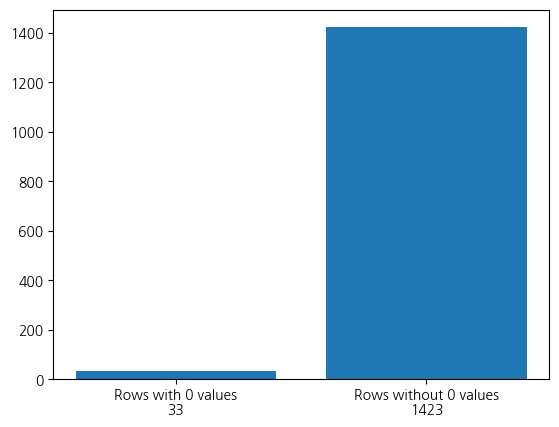

In [22]:
job_skill_matrix = job_skill_matrix_df.values
threshold = 0.6

filtered_matrix_2 = np.where(job_skill_matrix < threshold, 0, job_skill_matrix)

# Replace non-zero values with 1
filtered_matrix_2[filtered_matrix_2 != 0] = 1

# Count rows with at least one "1"
row_counts = np.sum(filtered_matrix_2, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = filtered_matrix_2.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

In [47]:
#to calcualte course specificity, start with making a bipartite network of course-job/skill
S = nx.Graph()

job_names = job_skill_matrix_df.index
skill_names = job_skill_matrix_df.columns

S.add_nodes_from(job_names, bipartite=0) 
S.add_nodes_from(skill_names, bipartite=1)   

for i in range(len(job_names)):
    job_name = job_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix_2[i, j]
        if value == 1:
            skill_name = skill_names[j]
            S.add_edge(job_name, skill_name)

In [49]:
#to calcualte course specificity, start with making a bipartite network of course-job/skill
S = nx.Graph()

job_names = job_skill_matrix_df.index
skill_names = job_skill_matrix_df.columns

S.add_nodes_from(job_names, bipartite=0) 
S.add_nodes_from(skill_names, bipartite=1)   

for i in range(len(job_names)):
    job_name = job_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix_2[i, j]
        if value == 1:
            skill_name = skill_names[j]
            S.add_edge(job_name, skill_name)

In [50]:
# Combine the Course-Skill network (B) and the Skill-Job network (S) into a unified network (T)
# - B represents the connections between courses and skills.
# - S represents the connections between skills and jobs.
T = nx.compose(B, S)

In [51]:
# Extract edge lists
course_skill_edges = [(source, target) for source, target in T.edges() if source in course_names and target in skill_names]
skill_job_edges = [(source, target) for source, target in T.edges() if source in skill_names and target in job_names]

# Create DataFrames for each edge list
course_skill_edgelist = pd.DataFrame(course_skill_edges, columns=['Course', 'Skill'])
skill_job_edgeslist = pd.DataFrame(skill_job_edges, columns=['Skill', 'Job'])
course_job_edgeslist = pd.merge(course_skill_edgelist, skill_job_edgeslist, on='Skill',how='left')

In [52]:
# Combine the course-skill and skill-job edge lists to create a course-job edge list.
# - The `course_skill_edgelist` contains edges between courses and skills.
# - The `skill_job_edgeslist` contains edges between skills and jobs.
course_job_edgeslist

,Course,Skill,Job
0,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,13420.HEA.02.009
1,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22200.HEA.03.007
2,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22200.HEA.06.008
3,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22680.HEA.03.003
4,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22680.HEA.06.002
...,...,...,...
2501499,Conflict Management,SSC-PDV-2008-1.1-1,34110.LEG.08.005
2501500,Conflict Management,SSC-PDV-2008-1.1-1,12121.HRM.07.003
2501501,Conflict Management,SSC-PDV-2008-1.1-1,12121.HRM.03.003
2501502,Conflict Management,SSC-PDV-2008-1.1-1,96211.HAS.01.006


# Aggregate OCS Index Analysis for Course-Job Connections by Sector

In [53]:
# Group course-job connections by 'Job' and count unique courses
course_job_counts = course_job_edgeslist.groupby('Job')['Course'].nunique().reset_index()
# 'id' represents the Job ID, and 'No.Jobs' indicates the count of unique courses linked to each job
course_job_counts.columns = ['id', 'No.Jobs']
course_job_counts = pd.merge(course_job_counts, df_job, on='id', how='left')
course_job_counts

,id,No.Jobs,job_label,tokenized_sentences,sector_label
0,11201.ACC.01.005,730,Financial Accounting/Management Accounting,['A Chief Financial Officer heads the finance ...,Accountancy
1,11201.AER.01.009,1025,Aircraft Engine / Component Maintenance,['A General Manager in Aircraft Engine and Com...,Aerospace
2,11201.AER.02.009,994,Aircraft Maintenance,['A General Manager in Aircraft Maintenance is...,Aerospace
3,11201.AER.03.009,1104,Manufacturing,['A General Manager in Manufacturing plans and...,Aerospace
4,11201.BIO.01.002,1224,General Management,['The Site Director steers the manufacturing p...,Biopharmaceuticals Manufacturing
...,...,...,...,...,...
1409,96211.HAS.01.004,163,Front Office,"[""A Concierge is the contact person for guests...",Hotel and Accommodation Services
1410,96211.HAS.01.005,994,Front Office,"[""Supporting the Chef Concierge or Front Offic...",Hotel and Accommodation Services
1411,96211.HAS.01.006,1047,Front Office,['A Chef Concierge oversees all aspects of the...,Hotel and Accommodation Services
1412,96212.HAS.01.001,2,Front Office,['Usually the first to welcome arriving guests...,Hotel and Accommodation Services


In [54]:
# Step 1: Calculate overall average number of jobs
overall_avg = course_job_counts['No.Jobs'].mean()

# Step 2: Calculate oversupply index for each sector
course_job_counts['OCS Index'] = course_job_counts['No.Jobs'] / overall_avg
course_job_counts

,id,No.Jobs,job_label,tokenized_sentences,sector_label,OCS Index
0,11201.ACC.01.005,730,Financial Accounting/Management Accounting,['A Chief Financial Officer heads the finance ...,Accountancy,1.557473
1,11201.AER.01.009,1025,Aircraft Engine / Component Maintenance,['A General Manager in Aircraft Engine and Com...,Aerospace,2.186863
2,11201.AER.02.009,994,Aircraft Maintenance,['A General Manager in Aircraft Maintenance is...,Aerospace,2.120724
3,11201.AER.03.009,1104,Manufacturing,['A General Manager in Manufacturing plans and...,Aerospace,2.355411
4,11201.BIO.01.002,1224,General Management,['The Site Director steers the manufacturing p...,Biopharmaceuticals Manufacturing,2.611434
...,...,...,...,...,...,...
1409,96211.HAS.01.004,163,Front Office,"[""A Concierge is the contact person for guests...",Hotel and Accommodation Services,0.347765
1410,96211.HAS.01.005,994,Front Office,"[""Supporting the Chef Concierge or Front Offic...",Hotel and Accommodation Services,2.120724
1411,96211.HAS.01.006,1047,Front Office,['A Chef Concierge oversees all aspects of the...,Hotel and Accommodation Services,2.233801
1412,96212.HAS.01.001,2,Front Office,['Usually the first to welcome arriving guests...,Hotel and Accommodation Services,0.004267


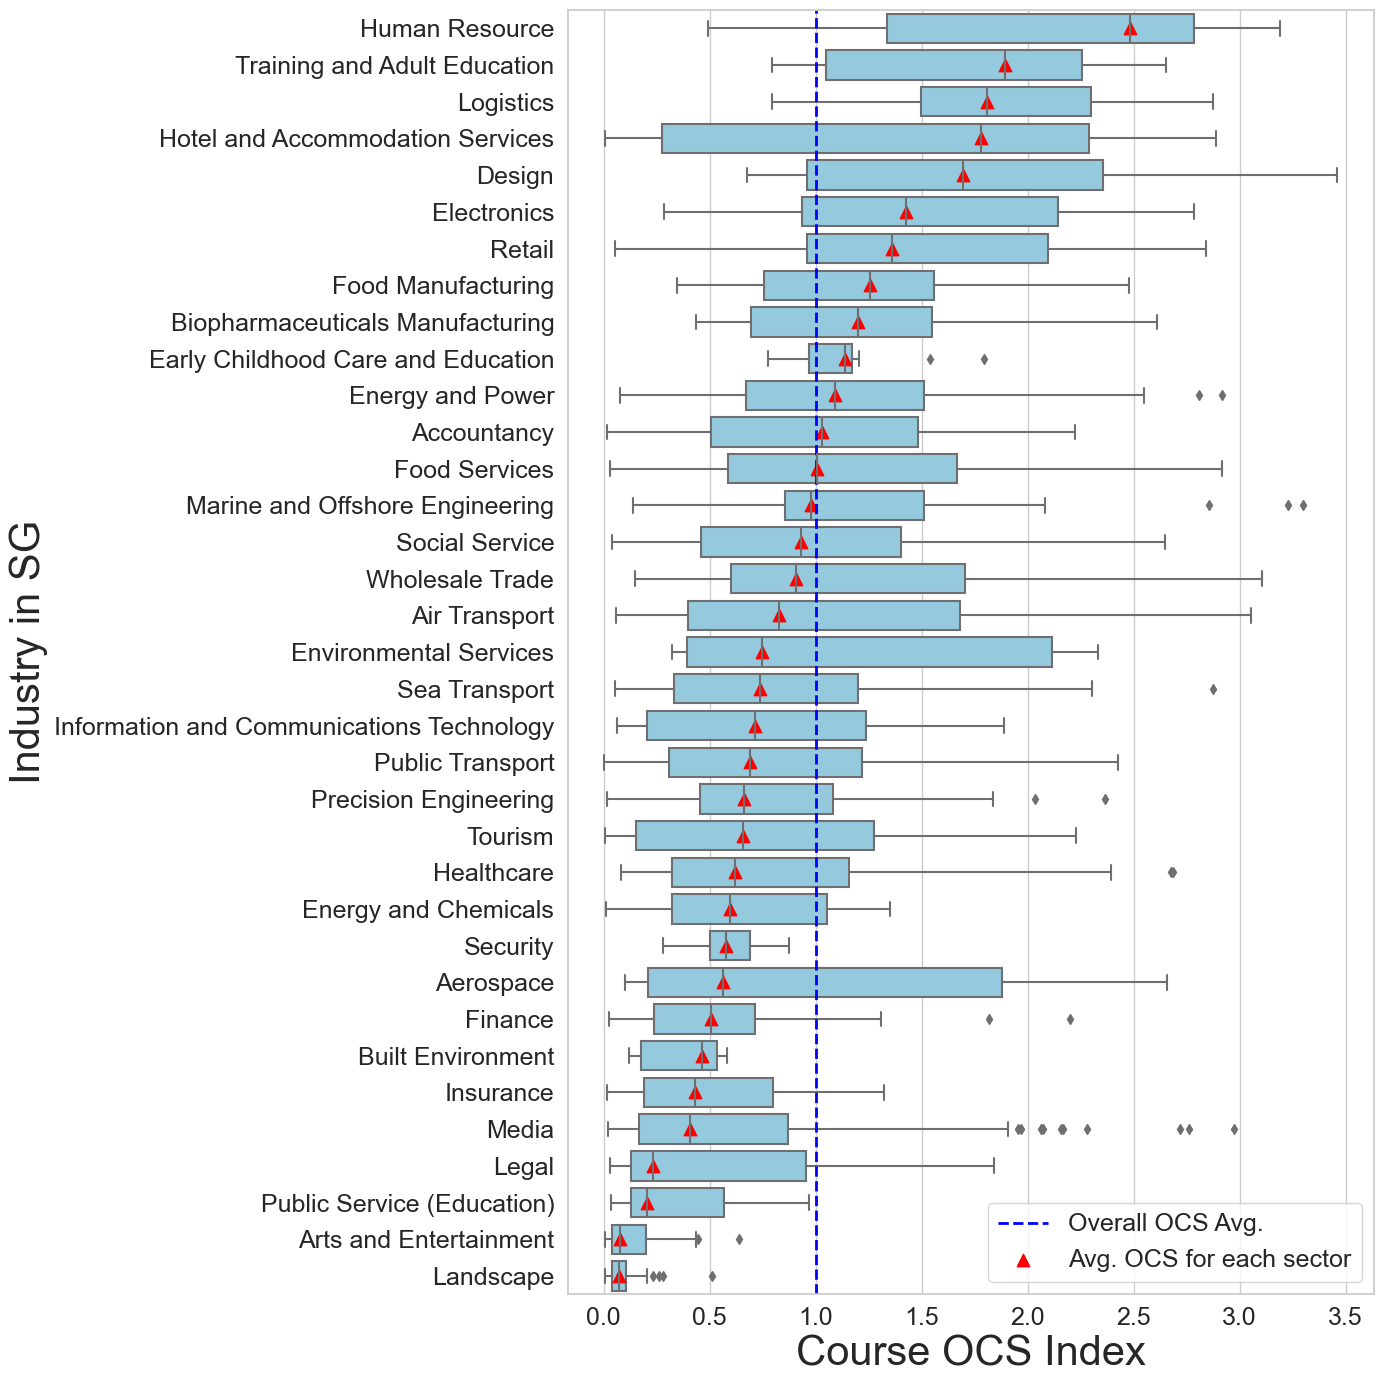

In [56]:
# Calculate average 'Oversupply Index' for each 'sector_label'
average_oversupply = course_job_counts.groupby('sector_label')['OCS Index'].median().reset_index()

# Sort the DataFrame based on the average 'Oversupply Index' in descending order
sorted_df = average_oversupply.sort_values(by='OCS Index', ascending=False)

# Replace 'your_data' and 'your_target_variable' with your actual data and target variable
sns.set(style="whitegrid")
plt.figure(figsize=(14, 14))

# Use boxplot to show the distribution of 'Oversupply Index' for each 'sector_label'
boxplot = sns.boxplot(x="OCS Index", y="sector_label", data=course_job_counts, order=sorted_df['sector_label'], orient="h", color='skyblue')  # Set color to 'skyblue'

# Add triangles for the average values
for i, value in enumerate(sorted_df['OCS Index']):
    plt.scatter(value, i, color='red', marker='^', s=80, label='Avg. OCS for each sector' if i == 0 else '')

# Set labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Course OCS Index", fontsize=30)
plt.ylabel("Industry in SG", fontsize=30)

# Add a vertical line for overall oversupply average
boxplot.axvline(x=1, color='blue', linestyle='--', linewidth=2, label='Overall OCS Avg.')

# Add legend
plt.legend(fontsize=18)

plt.tight_layout()
plt.savefig('ocs_index_sector.png', bbox_inches='tight', dpi=300)

plt.show()

# Extracting Transferability Metrics and Analyzing Correlation with OCS Index

In [78]:
df_skill_original = pd.read_csv('df_skill_original.csv')

def process_csv(csv_filename, transferability_category, network_name):
    # Read CSV file
    skill_data = pd.read_csv(csv_filename)
    # Rename columns if necessary
    skill_data = skill_data.rename(columns={'Title of Priority Skill': 'TSC_CCS Title', 'Description of Priority Skill': 'TSC_CCS Description'})
    # Merge with original skill data
    skill_data = pd.merge(skill_data, df_skill_original, on=['TSC_CCS Title', 'TSC_CCS Description'], how='left')
    # Drop rows with missing values
    skill_data = skill_data.dropna()
    # Select relevant columns
    skill_data = skill_data[['TSC_CCS Code', 'TSC_CCS Title', 'TSC_CCS Description', 'Transferability']]
    # Create a dictionary from the DataFrame
    skills_transferability = skill_data.set_index('TSC_CCS Code')['Transferability'].to_dict()

    # Assign values to the network nodes
    for skill_name in skill_names:
        if skill_name in skills_transferability:
            value = skills_transferability[skill_name]
            S.nodes[skill_name][f'{transferability_category}_transferability'] = value

    for job_name in job_names:
        # Find neighbors of job_name node
        neighbors = list(S.neighbors(job_name))

        # Sum the total transferability value from neighbor skill nodes
        total_transferability = 0
        for neighbor in neighbors:
            if f'{transferability_category}_transferability' in S.nodes[neighbor]:
                total_transferability += S.nodes[neighbor][f'{transferability_category}_transferability']
        # Assign the total transferability value to the job node
        S.nodes[job_name][f'total_{transferability_category}_transferability'] = total_transferability

In [79]:
process_csv('Care Economy.csv', 'care', 'S')
process_csv('Green Economy.csv', 'green', 'S')
process_csv('Digital Economy.csv', 'digital', 'S')
process_csv('I4.0 Economy.csv', 'i40', 'S')

In [80]:
labels_skill = {node: row['skill_label'] for node, row in df_skill.set_index('id').iterrows()}
labels_job = {node: row['job_label'] for node, row in df_job.set_index('id').iterrows()}

for node in S.nodes():
    if S.nodes[node]['bipartite'] == 0:
        S.nodes[node]['job_label'] = labels_job.get(node)
    elif S.nodes[node]['bipartite'] == 1:
        S.nodes[node]['skill_label'] = labels_skill.get(node) 

sector_data = df_job.set_index('id')['sector_label'].to_dict()

for job_name in job_names:
    if job_name in sector_data:
        value = sector_data[job_name]
        S.nodes[job_name]['sector_label'] = value  # Use 'industry' consistently

In [87]:
job_projection = nx.bipartite.projected_graph(S, job_names)

transferability_types = ['total_care_transferability', 'total_green_transferability', 'total_i40_transferability', 'total_digital_transferability']

# Initialize a dictionary to store results for each transferability type
transferability_results = {}

# Iterate over each transferability type
for transferability_type in transferability_types:
    sector_transferability = {}

    # Traverse through each job in the bipartite network
    for job_name in job_names:
        sector_label = S.nodes[job_name]['sector_label']
        transferability = S.nodes[job_name][transferability_type]

        # Update the dictionary with cumulative transferability and count
        if sector_label not in sector_transferability:
            sector_transferability[sector_label] = {'sum_transferability': 0, 'count': 0}
        sector_transferability[sector_label]['sum_transferability'] += transferability
        sector_transferability[sector_label]['count'] += 1

    # Calculate median transferability for each sector_label
    median_transferability = {}
    for sector_label, values in sector_transferability.items():
        transferability_values = [S.nodes[job_name][transferability_type] for job_name in job_names if S.nodes[job_name]['sector_label'] == sector_label]
        median_transferability[sector_label] = np.median(transferability_values)

    # Store the results in the dictionary
    transferability_results[transferability_type] = pd.DataFrame(list(median_transferability.items()), columns=['sector_label', f'median_{transferability_type}'])

# Merge the results into a single DataFrame
final_result = pd.DataFrame({'sector_label': transferability_results['total_care_transferability']['sector_label']})
for transferability_type in transferability_types:
    final_result = pd.merge(final_result, transferability_results[transferability_type], on='sector_label')

coursesupply_transferability = pd.merge(average_oversupply, final_result, on='sector_label', how='left')
coursesupply_transferability.head()

,sector_label,OCS Index,median_total_care_transferability,median_total_green_transferability,median_total_i40_transferability,median_total_digital_transferability
0,Accountancy,1.028359,1063.0,0.0,669.0,931.0
1,Aerospace,0.562184,0.0,0.0,1973.5,43.0
2,Air Transport,0.828874,30.0,0.0,398.0,271.0
3,Arts and Entertainment,0.075740,0.0,0.0,0.0,0.0
4,Biopharmaceuticals Manufacturing,1.199041,188.0,0.0,5057.0,1880.0


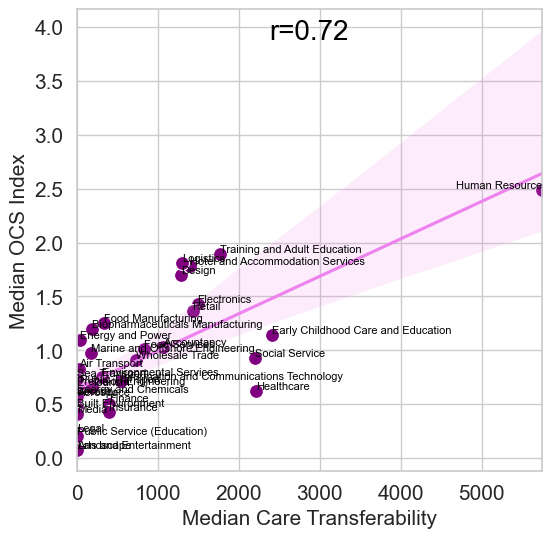

In [88]:
# Create a scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='median_total_care_transferability', y='OCS Index', data=coursesupply_transferability, color='purple', s=100)

# Draw a fitted line (regression line)
sns.regplot(x='median_total_care_transferability', y='OCS Index', data=coursesupply_transferability, scatter=False, color='violet')

# Calculate the correlation coefficient'b
correlation_coefficient = coursesupply_transferability['median_total_care_transferability'].corr(coursesupply_transferability['OCS Index'])

# Annotate each point with its corresponding label
for label, x, y in zip(coursesupply_transferability['sector_label'], coursesupply_transferability['median_total_care_transferability'], coursesupply_transferability['OCS Index']):
    ha_value = 'left' if label != 'Human Resource' else 'right'
    plt.text(x, y, label, fontsize=8, ha=ha_value, va='bottom', color='black')

    
# Annotate the plot with the correlation coefficient
plt.annotate(f'r={correlation_coefficient:.2f}',
             xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', va='center', fontsize=20, color='black')

# Set x-axis limits
plt.xlabel('Median Care Transferability', fontsize=15)
plt.ylabel('Median OCS Index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

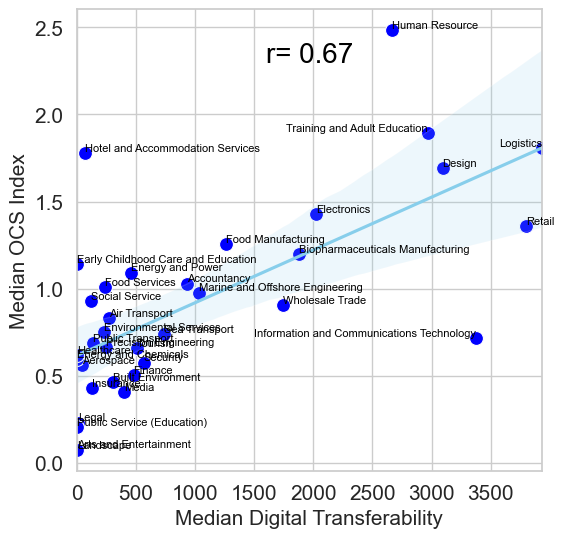

In [89]:
# Create a scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='median_total_digital_transferability', y='OCS Index', data=coursesupply_transferability, color='blue', s=100)

# Draw a fitted line (regressi line)
sns.regplot(x='median_total_digital_transferability', y='OCS Index', data=coursesupply_transferability, scatter=False, color='skyblue')

# Calculate the correlation coefficient'b
correlation_coefficient = coursesupply_transferability['median_total_digital_transferability'].corr(coursesupply_transferability['OCS Index'])
#plt.text(0.05, 0.9, f'Pearson Correlation: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, fontsize=12)

# Annotate each point with its corresponding label
for label, x, y in zip(coursesupply_transferability['sector_label'], coursesupply_transferability['median_total_digital_transferability'], coursesupply_transferability['OCS Index']):
    ha_value = 'left' if label not in ['Training and Adult Education','Information and Communications Technology', 'Logistics'] else 'right'
    plt.text(x, y, label, fontsize=8, ha=ha_value, va='bottom', color='black')

    
# Annotate the plot with the correlation coefficient
plt.annotate(f'r= {correlation_coefficient:.2f}',
             xy=(0.5, 0.90), xycoords='axes fraction',
             ha='center', va='center', fontsize=20, color='black')

# Set x-axis limits
plt.xlabel('Median Digital Transferability', fontsize=15)
plt.ylabel('Median OCS Index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

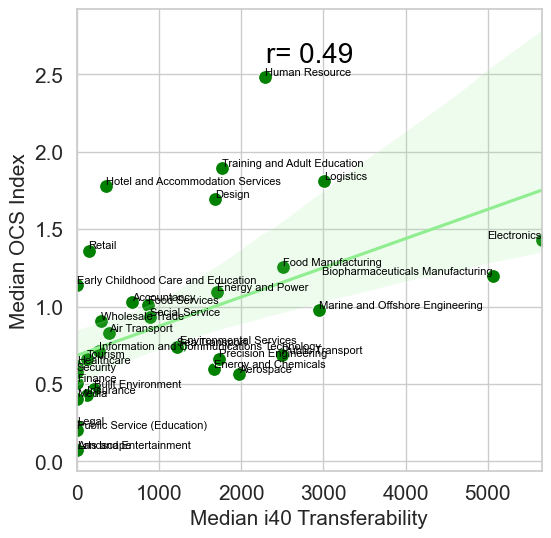

In [90]:
# Create a scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='median_total_i40_transferability', y='OCS Index', data=coursesupply_transferability, color='green', s=100)

# Draw a fitted line (regression line)
sns.regplot(x='median_total_i40_transferability', y='OCS Index', data=coursesupply_transferability, scatter=False, color='lightgreen')
# Calculate the correlation coefficient'b
correlation_coefficient = coursesupply_transferability['median_total_i40_transferability'].corr(coursesupply_transferability['OCS Index'])
#plt.text(0.05, 0.9, f'Pearson Correlation: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, fontsize=12)

# Annotate each point with its corresponding label
for label, x, y in zip(coursesupply_transferability['sector_label'], coursesupply_transferability['median_total_i40_transferability'], coursesupply_transferability['OCS Index']):
    ha_value = 'left' if label not in ['Electronics',"Biopharmaceuticals Manufacturing"] else 'right'
    plt.text(x, y, label, fontsize=8, ha=ha_value, va='bottom', color='black')

    
# Annotate the plot with the correlation coefficient
plt.annotate(f'r= {correlation_coefficient:.2f}',
             xy=(0.5, 0.90), xycoords='axes fraction',
             ha='center', va='center', fontsize=20, color='black')

# Set x-axis limits
plt.xlabel('Median i40 Transferability', fontsize=15)
plt.ylabel('Median OCS Index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()